In [1]:
from cv2 import aruco
import cv2
import numpy as np
import matplotlib.pyplot as plt
import msgpack as mp
import msgpack_numpy as mpn
import os

from tqdm import tqdm
import csv

from joblib import Parallel, delayed

In [2]:
# Formats: SEGMENTATION, CLASSIFICATION, POSE
DATASET_FORMAT = "POSE"
RECORDING_TYPE = "MULTIVIDEO"
FILTER_BASED = True

In [4]:
# _pth = os.getcwd()
_pth = r"E:\aruco_recent_recordings\data_for_labelling_aug_1_2023"
_pth = os.path.dirname(_pth)
_parent_folder = "data_for_labelling_aug_1_2023"
_calib_folder_name = "calibration_00"

_folder_name = "mip_brd_30_4_0"
# _folder_name = "board"

# _base_pth = os.path.join(_pth,"recorded_data",_parent_folder)
_base_pth = os.path.join(_pth,_parent_folder)

# _webcam_calib_folder = os.path.join(_pth,"recorded_data",_parent_folder,_calib_folder_name)
_webcam_calib_folder = os.path.join(_pth,_parent_folder,_calib_folder_name)
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join( _webcam_calib_folder, "webcam_calibration.msgpack")

with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

_webcam_cam_mat

array([[671.25534529,   0.        , 678.00736213],
       [  0.        , 692.23316717, 443.37269229],
       [  0.        ,   0.        ,   1.        ]])

In [5]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_MIP_36H12)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = int(_folder_name.split("_")[3])/100
markerSeperation = 0.01

board = aruco.GridBoard(
        size= [1,1],
        markerLength=markerLength,
        markerSeparation=markerSeperation,
        dictionary=ARUCO_DICT)

In [6]:
video_folders_pth = os.path.join(_base_pth)
video_folders_list = os.listdir(video_folders_pth)
video_folders_list = video_folders_list[4:]
_text_pth = os.path.join(_webcam_calib_folder, "..", "00_analysis", "folder_names.txt")

In [7]:
"""write folder names to text file"""
with open(_text_pth, "w") as f:
    for i in video_folders_list:
        # f.write(i + "\n")
        pass

In [8]:
with open(_text_pth, "r") as f:
    video_folders_list = f.readlines()
    video_folders_list = [i.strip() for i in video_folders_list]

In [34]:
# video_folders_list = video_folders_list[0:2]

In [9]:
video_folders_list

['mip_quad_30_5_0', 'mip_quad_30_5_1', 'mip_quad_30_5_2']

In [10]:
marker_size = markerLength

marker_points = np.array([[-marker_size / 2, marker_size / 2, 0],
                            [marker_size / 2, marker_size / 2, 0],
                            [marker_size / 2, -marker_size / 2, 0],
                            [-marker_size / 2, -marker_size / 2, 0]], dtype=np.float32)

def my_estimatePoseSingleMarkers(corners, marker_points, mtx, distortion):
    trash = []
    rvecs = []
    tvecs = []
    for c in corners:
        nada, R, t = cv2.solvePnP(marker_points, c, mtx, distortion, False, flags= cv2.SOLVEPNP_ITERATIVE)
        R = R.T
        t = t.T
        rvecs.append(R)
        tvecs.append(t)
        trash.append(nada)
    return rvecs, tvecs, trash

In [11]:

default_ids = [12, 88, 89]
data = {"frame_id":[],"marker_ids":[], "corners":[], "tvec":[], "rvec":[]}

counter = 0

detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)

for _folder_name in video_folders_list:
    _video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")
    _video_file = open(_video_pth, "rb")
    _video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)
    
    markerLength = int(_folder_name.split("_")[3])/100

    
    for _frame in tqdm(_video_data):

        shape = _frame.shape
        gray = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)
        
        corners, ids, rejectedImgPoints = detector.detectMarkers(gray)
        corners, ids, rejectedImgPoints,_ = detector.refineDetectedMarkers(image=gray,board=board ,detectedCorners=corners, detectedIds=ids, 
                                                                        rejectedCorners=rejectedImgPoints, cameraMatrix=_webcam_cam_mat, 
                                                                        distCoeffs=_webcam_dist)

        rotation_vectors, translation_vectors, _ = my_estimatePoseSingleMarkers(corners, marker_points, _webcam_cam_mat, _webcam_dist)

        if ids is None:
            data["frame_id"].append(counter)
            data["marker_ids"].append(None)
            data["corners"].append(None)
            data["tvec"].append(None)
            data["rvec"].append(None)

        if ids is not None:
            data["frame_id"].append(counter)
            data["marker_ids"].append(ids)
            data["corners"].append(corners)
            data["tvec"].append(translation_vectors)
            data["rvec"].append(rotation_vectors)

        counter+=1

    _video_file.close()

717it [00:11, 60.29it/s]
542it [00:08, 63.05it/s]
693it [00:11, 59.78it/s]


In [31]:
data["tvec"][0][0][0]

array([-0.05036781,  0.00373563,  0.51252504])

In [12]:
coordinate = {str(default_ids[0]):{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              str(default_ids[1]):{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              str(default_ids[2]):{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]}}

doesnt_exist = [] # list of ids that doesnt exist in a frame

for i in range(len(data["frame_id"])):
    if data["marker_ids"][i] is not None:

        if default_ids[0] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[0])
        if default_ids[1] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[1])
        if default_ids[2] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[2])

        for j in range(len(data["marker_ids"][i])):
            if data["marker_ids"][i][j] in default_ids:
                coordinate[str(data["marker_ids"][i][j][0])]["x"].append(data["tvec"][i][j][0][0])
                coordinate[str(data["marker_ids"][i][j][0])]["y"].append(data["tvec"][i][j][0][1])
                coordinate[str(data["marker_ids"][i][j][0])]["z"].append(data["tvec"][i][j][0][2])
                coordinate[str(data["marker_ids"][i][j][0])]["rx"].append(data["rvec"][i][j][0][0])
                coordinate[str(data["marker_ids"][i][j][0])]["ry"].append(data["rvec"][i][j][0][1])
                coordinate[str(data["marker_ids"][i][j][0])]["rz"].append(data["rvec"][i][j][0][2])
        for k in doesnt_exist:
            coordinate[str(k)]["x"].append(np.nan)
            coordinate[str(k)]["y"].append(np.nan)
            coordinate[str(k)]["z"].append(np.nan)
            coordinate[str(k)]["rx"].append(np.nan)
            coordinate[str(k)]["ry"].append(np.nan)
            coordinate[str(k)]["rz"].append(np.nan)
        doesnt_exist = []
    else:
        for k in default_ids:
            coordinate[str(k)]["x"].append(np.nan)
            coordinate[str(k)]["y"].append(np.nan)
            coordinate[str(k)]["z"].append(np.nan)
            coordinate[str(k)]["rx"].append(np.nan)
            coordinate[str(k)]["ry"].append(np.nan)
            coordinate[str(k)]["rz"].append(np.nan)

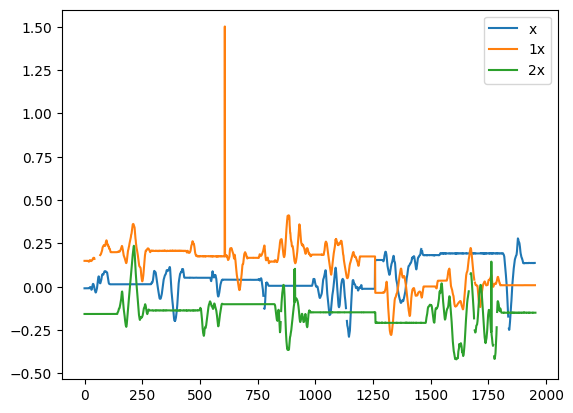

In [13]:
plt.plot(coordinate[str(default_ids[0])]["x"], label="x")
plt.plot(coordinate[str(default_ids[1])]["x"], label="1x")
plt.plot(coordinate[str(default_ids[2])]["x"], label="2x")
plt.legend()

In [14]:
recording_objects = _folder_name.split("_")[1]
recording_objects

'quad'

In [16]:
raw_data_pth = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
raw_data_pth = os.path.join(raw_data_pth, 'dataset',"multi_class", "raw_data")
if not os.path.exists(raw_data_pth):
    os.makedirs(os.path.join(raw_data_pth, "images"))
    os.makedirs(os.path.join(raw_data_pth, "labels"))
    

# based on the coordinate, we can create the labels
# we will create the labels for each frame

counter = 0
file_remove = False
recording_objects = ""
total_frames = 0

for _folder_name in video_folders_list:

    doesnt_exist = [] # list of ids that doesnt exist in a frame
    _video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")
    _video_file = open(_video_pth, "rb")
    _video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

    _current_xvec_0 = 0.
    _current_yvec_0 = 0.
    _current_zvec_0 = 0.

    _previous_xvec_0 = 0.
    _previous_yvec_0 = 0.
    _previous_zvec_0 = 0.
    
    _current_xvec_49 = 0.
    _current_yvec_49 = 0.
    _current_zvec_49 = 0.

    _previous_xvec_49 = 0.
    _previous_yvec_49 = 0.
    _previous_zvec_49 = 0.
    
    _current_xvec_80 = 0.
    _current_yvec_80 = 0.
    _current_zvec_80 = 0.

    _previous_xvec_80 = 0.
    _previous_yvec_80 = 0.
    _previous_zvec_80 = 0.

    _start_frame_counter = 0
    
    markerLength = int(_folder_name.split("_")[3])/100
    
    recording_objects = _folder_name.split("_")[1]
    


    for _frame in tqdm(_video_data):

        shape = _frame.shape
        height, width, _ = shape
        gray = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)        
        
        markerCorners, ids, rejectedImgPoints = detector.detectMarkers(gray)

        markerCorners, ids, rejectedImgPoints, recoveredIds = detector.refineDetectedMarkers(image=gray,board=board ,detectedCorners=markerCorners, detectedIds=ids, 
                                                                        rejectedCorners=rejectedImgPoints, cameraMatrix=_webcam_cam_mat, 
                                                                        distCoeffs=_webcam_dist)
        
        rotation_vectors, translation_vectors, _ = my_estimatePoseSingleMarkers(markerCorners, marker_points, _webcam_cam_mat, _webcam_dist)
        
        total_frames += 1

        if len(markerCorners) == 0:
            counter += 1
            continue
        
        if FILTER_BASED and (recording_objects=="brd" or recording_objects == "obj") and (len(ids) != 3):
            counter += 1
            continue
        


        img_name = f"image_{counter}.png"

        label_name = img_name.split(".")[0]
        label_path = os.path.join(raw_data_pth, "labels", f"{label_name}.txt")
        label_file = open(label_path, "w", newline='')
        label_writer = csv.writer(label_file, delimiter=" ")

        _class_name = ""

        if default_ids[0] not in ids:
            doesnt_exist.append(default_ids[0])
        if default_ids[1] not in ids:
            doesnt_exist.append(default_ids[1])
        if default_ids[2] not in ids:
            doesnt_exist.append(default_ids[2])

        for i in range(len(ids)):

            if ids[i][0] == 0:
                if _start_frame_counter == 0:

                    _previous_xvec_0 = translation_vectors[i][0][0]
                    _previous_yvec_0 = translation_vectors[i][0][1]
                    _previous_zvec_0 = translation_vectors[i][0][2]

                _current_xvec_0 = translation_vectors[i][0][0]
                _current_yvec_0 = translation_vectors[i][0][1]
                _current_zvec_0 = translation_vectors[i][0][2]

                if abs(_current_xvec_0 - _previous_xvec_0)>0.1:
                    file_remove = True
                elif abs(_current_yvec_0 - _previous_yvec_0)>0.1:
                    file_remove = True
                elif abs(_current_zvec_0 - _previous_zvec_0)>0.1:
                    file_remove = True

                _previous_xvec_0 = _current_xvec_0
                _previous_yvec_0 = _current_yvec_0
                _previous_zvec_0 = _current_zvec_0
                
            if ids[i][0] == 1:
                
                if _start_frame_counter == 0:

                    _previous_xvec_49 = translation_vectors[i][0][0]
                    _previous_yvec_49 = translation_vectors[i][0][1]
                    _previous_zvec_49 = translation_vectors[i][0][2]

                _current_xvec_49 = translation_vectors[i][0][0]
                _current_yvec_49 = translation_vectors[i][0][1]
                _current_zvec_49 = translation_vectors[i][0][2]

                if abs(_current_xvec_49 - _previous_xvec_49)>0.1:
                    file_remove = True
                elif abs(_current_yvec_49 - _previous_yvec_49)>0.1:
                    file_remove = True
                elif abs(_current_zvec_49 - _previous_zvec_49)>0.1:
                    file_remove = True

                _previous_xvec_49 = _current_xvec_49
                _previous_yvec_49 = _current_yvec_49
                _previous_zvec_49 = _current_zvec_49
                
            if ids[i][0] == 2:
                
                if _start_frame_counter == 0:

                    _previous_xvec_80 = translation_vectors[i][0][0]
                    _previous_yvec_80 = translation_vectors[i][0][1]
                    _previous_zvec_80 = translation_vectors[i][0][2]

                _current_xvec_80 = translation_vectors[i][0][0]
                _current_yvec_80 = translation_vectors[i][0][1]
                _current_zvec_80 = translation_vectors[i][0][2]

                if abs(_current_xvec_80 - _previous_xvec_80)>0.1:
                    file_remove = True
                elif abs(_current_yvec_80 - _previous_yvec_80)>0.1:
                    file_remove = True
                elif abs(_current_zvec_80 - _previous_zvec_80)>0.1:
                    file_remove = True

                _previous_xvec_80 = _current_xvec_80
                _previous_yvec_80 = _current_yvec_80
                _previous_zvec_80 = _current_zvec_80
                

            _markerCorners = markerCorners[i][0]
            bbox_x,bbox_y,bbox_width,bbox_height = cv2.boundingRect(_markerCorners)

            bbox_x = bbox_x / width
            bbox_y = bbox_y / height

            bbox_center_x = bbox_x + bbox_width / (2 * width)
            bbox_center_y = bbox_y + bbox_height / (2 * height)

            bbox_width = bbox_width / width
            bbox_height = bbox_height / height
            if ids[i][0] == default_ids[0]:
                _class_name = "0"
            elif ids[i][0] == default_ids[1]:
                _class_name = "1"
            elif ids[i][0] == default_ids[2]:
                _class_name = "2"
            else:
                continue
            
            if DATASET_FORMAT == "SEGMENTATION":
                label_writer.writerow([_class_name,_markerCorners[0][0]/width, _markerCorners[0][1]/height, _markerCorners[1][0]/width, _markerCorners[1][1]/height, _markerCorners[2][0]/width, _markerCorners[2][1]/height, _markerCorners[3][0]/width, _markerCorners[3][1]/height, _markerCorners[0][0]/width, _markerCorners[0][1]/height])
            elif DATASET_FORMAT == "POSE":
                label_writer.writerow([_class_name, bbox_center_x, bbox_center_y, bbox_width, bbox_height,_markerCorners[0][0]/width, _markerCorners[0][1]/height, _markerCorners[1][0]/width, _markerCorners[1][1]/height, _markerCorners[2][0]/width, _markerCorners[2][1]/height, _markerCorners[3][0]/width, _markerCorners[3][1]/height, _markerCorners[0][0]/width, _markerCorners[0][1]/height])


        label_file.close()
        doesnt_exist = []
        # save image
        image_path = os.path.join(raw_data_pth, "images", img_name)
        cv2.imwrite(image_path, _frame)
        
        if file_remove:
            os.remove(image_path)
            os.remove(label_path)
            file_remove = False
        counter += 1
        _start_frame_counter += 1

    _video_file.close()

717it [00:33, 21.45it/s]
542it [00:21, 25.63it/s]
693it [00:30, 22.74it/s]


In [17]:
print(total_frames, counter, counter/total_frames)

1952 1952 1.0


In [18]:
def gaussian_blur(image):
    return cv2.GaussianBlur(image, (3, 35), 0)

In [19]:
def add_noise(image):
    img = image[...,::-1]/255.0
    noise =  np.random.normal(loc=0, scale=1, size=img.shape)
    noisy2 = np.clip((img + noise*0.4),0,1)
    noisy2 = (noisy2*255).astype(np.uint8)
    noisy2 = noisy2[...,::-1]
    return noisy2

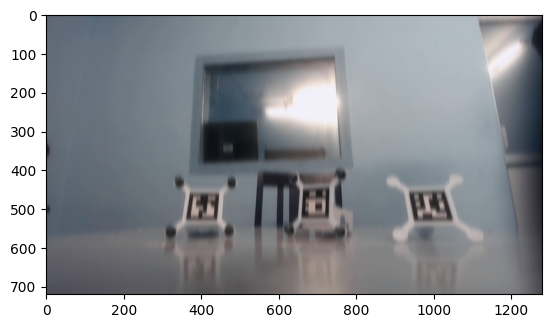

In [20]:
plt.imshow(gaussian_blur(_frame))


In [21]:
num_processes = 20  # You can adjust this based on your requirements

In [22]:
_raw_saved_data_pth = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
_raw_saved_data_pth = os.path.join(_raw_saved_data_pth, 'dataset',"multi_class", "raw_data")
_raw_saved_data_pth = os.path.join(_raw_saved_data_pth, "images")
_raw_saved_data_list = os.listdir(_raw_saved_data_pth)

def add_noise(image):
    img = image[...,::-1]/255.0
    noise =  np.random.normal(loc=0, scale=1, size=img.shape)
    noisy2 = np.clip((img + noise*0.4),0,1)
    noisy2 = (noisy2*255).astype(np.uint8)
    noisy2 = noisy2[...,::-1]
    return noisy2

def gaussian_blur(image):
    return cv2.GaussianBlur(image, (3, 35), 0)


def adding_noise_to_image(img_name):
    _image_path = os.path.join(_raw_saved_data_pth, img_name)
    image = cv2.imread(_image_path)
    #adding noise to twenty percent of the images
    _csv_rows = []
    if np.random.random() < 0.4:
        image = gaussian_blur(image)
        _image_path = os.path.join(_raw_saved_data_pth, f"blur_{img_name}")
        cv2.imwrite(_image_path, image)

        label_name = img_name.split(".")[0]
        label_path = os.path.join(_raw_saved_data_pth, "..","labels", f"{label_name}.txt")
        label_file = open(label_path, "r", newline='')
        label_reader = csv.reader(label_file, delimiter=" ")
        for _row in label_reader:
            _csv_rows.append(_row)
        label_file.close()

        label_path = os.path.join(os.path.join(_raw_saved_data_pth, "..", "labels"), f"blur_{img_name.split('.')[0]}.txt")
        label_file = open(label_path, "w", newline='')
        label_writer = csv.writer(label_file, delimiter=" ")
        for _r in _csv_rows:
            label_writer = csv.writer(label_file, delimiter=" ")
            label_writer.writerow(_r)
            
        _csv_rows.clear()
        label_file.close()
    
    if np.random.random() > 0.3 and np.random.random()<0.6:
        image = add_noise(image)        
        _image_path = os.path.join(_raw_saved_data_pth, f"noise_{img_name}")
        cv2.imwrite(_image_path, image)

        label_name = img_name.split(".")[0]
        label_path = os.path.join(_raw_saved_data_pth, "..","labels", f"{label_name}.txt")
        label_file = open(label_path, "r", newline='')
        label_reader = csv.reader(label_file, delimiter=" ")
        for _row in label_reader:
            _csv_rows.append(_row)
        label_file.close()

        label_path = os.path.join(os.path.join(_raw_saved_data_pth, "..", "labels"), f"noise_{img_name.split('.')[0]}.txt")
        label_file = open(label_path, "w", newline='')
        label_writer = csv.writer(label_file, delimiter=" ")
        for _r in _csv_rows:
            label_writer = csv.writer(label_file, delimiter=" ")
            label_writer.writerow(_r)
            
        _csv_rows.clear()
        label_file.close()
    return 0
        
results = Parallel(n_jobs=num_processes, verbose=1)(delayed(adding_noise_to_image)(element) for element in _raw_saved_data_list)


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    5.4s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   10.3s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   18.1s
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:   29.2s
[Parallel(n_jobs=20)]: Done 1760 tasks      | elapsed:   42.5s
[Parallel(n_jobs=20)]: Done 1940 out of 1940 | elapsed:   46.0s finished


In [23]:
# splitting dataset into train and validation and test
data_pth = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_pth = os.path.join(data_pth, 'dataset',"multi_class", "dataset_processed")

images_pth = os.path.join(data_pth, "images")
labels_pth = os.path.join(data_pth, "labels")

if not os.path.exists(images_pth):
    os.makedirs(os.path.join(images_pth, "train"))
    os.makedirs(os.path.join(images_pth, "val"))
    os.makedirs(os.path.join(images_pth, "test"))

if not os.path.exists(labels_pth):
    os.makedirs(os.path.join(labels_pth, "train"))
    os.makedirs(os.path.join(labels_pth, "val"))
    os.makedirs(os.path.join(labels_pth, "test"))
    
    
image_list = os.listdir(os.path.join(raw_data_pth, "images"))

def split_dataset(img_name):
    _image_path = os.path.join(raw_data_pth, "images", img_name)
    image = cv2.imread(_image_path)
    
    label_name = img_name.split(".")[0]
    label_path = os.path.join(raw_data_pth, "labels", f"{label_name}.txt")
    label_file = open(label_path, "r", newline='')
    label_reader = csv.reader(label_file, delimiter=" ")
    
    label = []
    for l in label_reader:
        label.append(l)
    
    label_file.close()
    
    # if int(label[0]) == 0:
    if np.random.rand() < 0.7:
        # save image
        image_path = os.path.join(os.path.join(images_pth, "train"), img_name)
        cv2.imwrite(image_path, image)
        
        label_path = os.path.join(os.path.join(labels_pth, "train"), f"{label_name}.txt")
        label_file = open(label_path, "w", newline='')
        label_writer = csv.writer(label_file, delimiter=" ")
        for l in label:
            label_writer.writerow(l)
        label_file.close()
        
    elif np.random.rand() < 0.9 and np.random.rand() > 0.7:
        # save image
        image_path = os.path.join(os.path.join(images_pth, "val"), img_name)
        cv2.imwrite(image_path, image)
        
        label_path = os.path.join(os.path.join(labels_pth, "val"), f"{label_name}.txt")
        label_file = open(label_path, "w", newline='')
        label_writer = csv.writer(label_file, delimiter=" ")
        for l in label:
            label_writer.writerow(l)
        label_file.close()
        
    else:
        # save image
        image_path = os.path.join(os.path.join(images_pth, "test"), img_name)
        cv2.imwrite(image_path, image)
        
        label_path = os.path.join(os.path.join(labels_pth, "test"), f"{label_name}.txt")
        label_file = open(label_path, "w", newline='')
        label_writer = csv.writer(label_file, delimiter=" ")
        for l in label:
            label_writer.writerow(l)
        label_file.close() 
        
    label.clear()
        
    return 0

results = Parallel(n_jobs=num_processes, verbose=1)(delayed(split_dataset)(element) for element in image_list)


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    7.3s
[Parallel(n_jobs=20)]: Done 1480 tasks      | elapsed:   12.9s
[Parallel(n_jobs=20)]: Done 2380 tasks      | elapsed:   20.1s
[Parallel(n_jobs=20)]: Done 3450 out of 3489 | elapsed:   31.7s remaining:    0.3s
[Parallel(n_jobs=20)]: Done 3489 out of 3489 | elapsed:   32.2s finished
